In [1]:
# import numpy, pandas and matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Function that converts pLab in sqrt(s)
def computeSqrts(pLab):
    """
        Given the magnitude of the proton beam momentum this function
        computes the respetive sqrt(s).
        The proton beam four momentum is (sqrt(mp**2+pLab**2), 0, 0, pLab)
        The proton four momentum is (mp,0,0,0) because it is at rest
        Then s = (p_gamma + mp)^2 - p_gamma^2
    """
    mp = 0.938
    # mass of the proton is 0.938 GeV
    return np.sqrt((mp+np.sqrt(mp*mp+pLab*pLab))**2-pLab*pLab)

In [3]:
# First we process the raw data into a new file format that can be read easily by pandas
f = open("SigmaProtonProton_raw.txt", "r")
new_f = open("SigmaProtonProton_new_raw.txt", "w")
string = f.readline()
while string != '':
    line_list = string.split()
    ref_list = line_list[9:]
    line_list = line_list[:9]
    new_line = '\t'.join(line_list)
    ref_string = " ".join(ref_list)
    new_f.write(new_line+'\t' + ref_string + '\n')
    string = f.readline()
f.close()
new_f.close()

In [4]:
# Read the new data file
# Define a pLab threshold for the data
pLabmin = 10
pLabmax = 10**7
exp_data_raw = pd.read_csv("SigmaProtonProton_new_raw.txt", sep = '\t')
condition = (exp_data_raw["PLAB(GEV/C)"] > pLabmin) & (exp_data_raw["PLAB(GEV/C)"] < pLabmax)
# Read pLab values as well their minimum and maximum values
pLab_vals = np.array(exp_data_raw[condition]["PLAB(GEV/C)"])
pLab_min_vals = np.array(exp_data_raw[condition]["PLAB_MIN"])
pLab_max_vals = np.array(exp_data_raw[condition]["PLAB_MAX"])
# Convert the pLab values into sqrt(s) values
sqrtS_vals = computeSqrts(pLab_vals)
sqrtS_min_vals = computeSqrts(pLab_min_vals)
sqrtS_max_vals = computeSqrts(pLab_max_vals)
sqrtS_err_plus = sqrtS_max_vals - sqrtS_vals
sqrtS_err_minus = sqrtS_vals - sqrtS_min_vals
# Read cross-section values
sigma_vals = np.array(exp_data_raw[condition]["SIG(MB)"])
# Compute the uncertainty of each point
stat_error_plus = np.array(exp_data_raw[condition]["STA_ERR+"])
stat_error_minus = np.array(exp_data_raw[condition]["STA_ERR-"])
# Compute the statistical error as the average
stat_error = 0.5 * (stat_error_plus + stat_error_minus)
# Systematic errors come in percentage
syst_error_plus = sigma_vals * np.array(exp_data_raw[condition]["SY_ER+(PCT)"]) / 100.0
syst_error_minus = sigma_vals * np.array(exp_data_raw[condition]["SY_ER-(PCT)"]) / 100.0
# Compute the systematic error as the average
syst_error = 0.5 * (syst_error_plus + syst_error_minus)
# Compute the total error as sqrt(stat_error**2 + syst_error**2)
error_vals = np.sqrt(stat_error**2 + syst_error**2)
# Create new data frame with columns ["sqrtS", "sqrtSErrorPlus", "sqrtSErrorMinus", "sigma", "Errorp", "Errorm"]
exp_data = pd.DataFrame({"W(GeV)":sqrtS_vals, "WErrorp":sqrtS_err_plus, "WErrorm":sqrtS_err_minus,
                        "sigma(mb)":sigma_vals, "Errorp":error_vals, "Errorm": error_vals})
exp_data.to_csv("SigmaProtonProton_data.txt", sep ='\t', index = False)

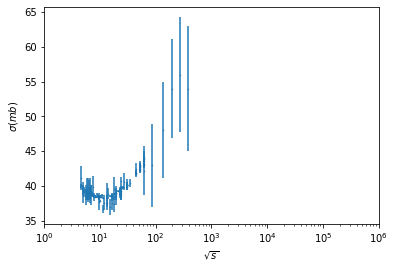

In [5]:
plt.errorbar(sqrtS_vals, sigma_vals, error_vals, fmt='o', markersize=0.5)
plt.xlabel(r'$\sqrt{s}$')
plt.ylabel(r'$\sigma(mb)$')
plt.xlim(1,10**6)
plt.xscale("log")